In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [8]:
# Parameters
m, b, k = 1, 0.1, 1.0

# Initial conditions
x0, v0 = 1.0, 0.0

def damped_harmonic_oscillator(y, t, m, b, k):
    x, v = y  # displacement, velocity
    a = -b/m * v - k/m * x  # acceleration
    return [v, a]

# Time points
t = np.linspace(0, 3*np.pi, 1000)

# Solve the differential equation
y0 = [x0, v0]  # initial conditions
sol = odeint(damped_harmonic_oscillator, y0, t, args=(m, b, k))

x0 = torch.tensor(x0)
v0 = torch.tensor(v0)

y0 = [x0,v0]

x = sol[:,0]

# Convert numpy arrays to PyTorch tensors
t = torch.from_numpy(t).view(-1,1).float()
x = torch.from_numpy(x).view(-1,1).float()

In [9]:
# Define the neural network
class DampedOscillatorNet(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        #self.m = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        #self.k = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Define the loss function
def loss_fn(x_pred, x_true):
    mse_loss = nn.MSELoss()
    loss = mse_loss(x_pred, x_true)

    return loss

def physics_loss_fn(x_pred, x_true,x_pred_eq, t_data_eq, m, b, k, y0):
    mse_loss = nn.MSELoss()
    displacement_loss = mse_loss(x_pred, x_true)
    
    dx = torch.autograd.grad(x_pred_eq, t_data_eq,torch.ones_like(x_pred_eq), create_graph=True)[0]
    d2x = torch.autograd.grad(dx, t_data_eq,torch.ones_like(dx), create_graph=True)[0]
    physics_loss = mse_loss(d2x, -b/m * dx - k/m * x_pred_eq)
   
    total_loss = displacement_loss + physics_loss
    
    return total_loss


In [10]:
# Initialize the network
model = DampedOscillatorNet(1,1,32,3)

Epoch: 100, Loss: 0.2863771319389343
Epoch: 200, Loss: 0.23351094126701355
Epoch: 300, Loss: 0.19687789678573608
Epoch: 400, Loss: 0.1787184774875641
Epoch: 500, Loss: 0.17163197696208954
Epoch: 600, Loss: 0.1668725311756134
Epoch: 700, Loss: 0.16268254816532135
Epoch: 800, Loss: 0.15877312421798706
Epoch: 900, Loss: 0.1550370305776596
Epoch: 1000, Loss: 0.15141412615776062
Epoch: 1100, Loss: 0.14785471558570862
Epoch: 1200, Loss: 0.14428047835826874
Epoch: 1300, Loss: 0.140496626496315
Epoch: 1400, Loss: 0.13597270846366882
Epoch: 1500, Loss: 0.1295323520898819
Epoch: 1600, Loss: 0.11978833377361298
Epoch: 1700, Loss: 0.10687652230262756
Epoch: 1800, Loss: 0.0927303284406662
Epoch: 1900, Loss: 0.07872729003429413
Epoch: 2000, Loss: 0.06517449766397476
Epoch: 2100, Loss: 0.052533891052007675
Epoch: 2200, Loss: 0.041279975324869156
Epoch: 2300, Loss: 0.03183100372552872
Epoch: 2400, Loss: 0.024294881150126457
Epoch: 2500, Loss: 0.018542002886533737
Epoch: 2600, Loss: 0.01430006790906190

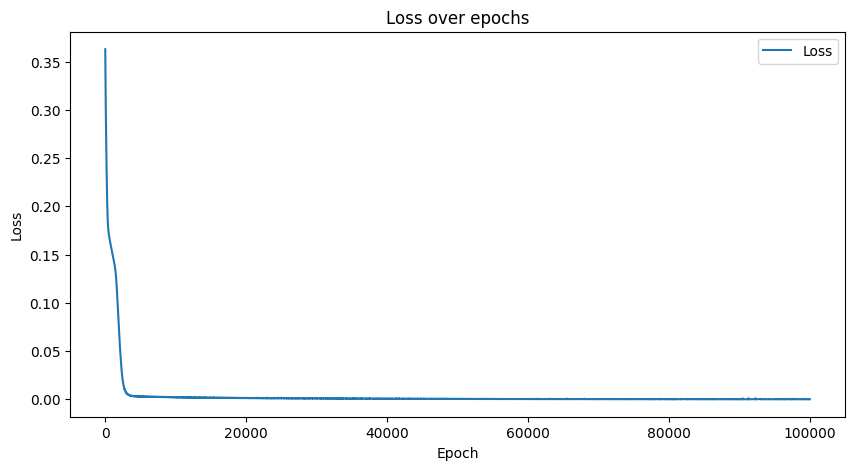

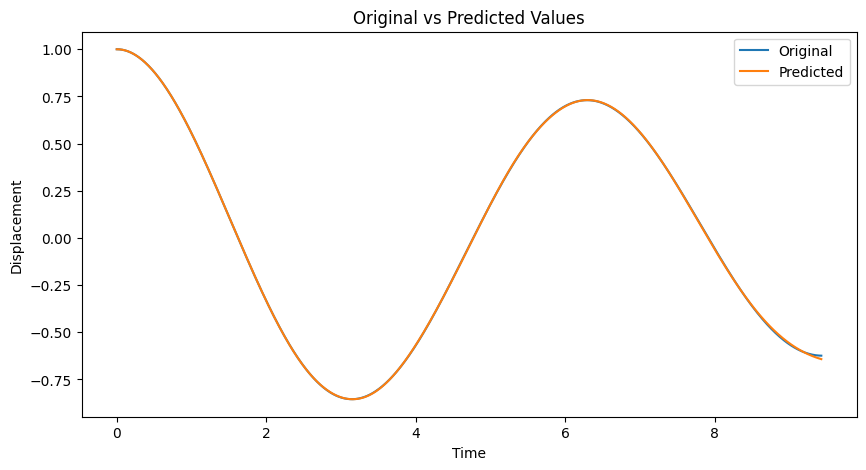

In [11]:
epochs = 100000
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
loss_values = []

# Initialize variables for early stopping
min_loss = np.inf
epochs_no_improve = 0
wait_for = 100
least_loss = 0

epoch = 0
while(True):
    epoch += 1
    optimizer.zero_grad()
    x_pred = model(t)
    loss = loss_fn(x_pred, x)
    epoch_loss = loss.item()
    loss_values.append(epoch_loss)
    loss.backward()
    optimizer.step()
    
    # Print the loss for every 100th epoch
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")

    if(loss<least_loss):
        break

    # Update early stopping variables
    if loss < min_loss:
        min_loss = loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check for early stopping
    if epochs_no_improve >= wait_for:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if epoch > epochs:
        break

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions on the training data
x_real = x.detach().numpy()
x_pred = model(t).detach().numpy()
t_np = t.detach().numpy()

# Plot the original and predicted values
plt.figure(figsize=(10, 5))
plt.plot(t_np, x_real, label='Original')
plt.plot(t_np, x_pred, label='Predicted')
plt.title('Original vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend()
plt.show()

Epoch: 100, Loss: 1.619924783706665
Epoch: 200, Loss: 1.6055258512496948
Epoch: 300, Loss: 1.5912210941314697
Epoch: 400, Loss: 1.5770084857940674
Epoch: 500, Loss: 1.562886118888855
Epoch: 600, Loss: 1.5488523244857788
Epoch: 700, Loss: 1.5349149703979492
Epoch: 800, Loss: 1.521062970161438
Epoch: 900, Loss: 1.5072933435440063
Epoch: 1000, Loss: 1.4936120510101318
Epoch: 1100, Loss: 1.4800177812576294
Epoch: 1200, Loss: 1.4665000438690186
Epoch: 1300, Loss: 1.4530713558197021
Epoch: 1400, Loss: 1.439720630645752
Epoch: 1500, Loss: 1.426448106765747
Epoch: 1600, Loss: 1.4132533073425293
Epoch: 1700, Loss: 1.4001399278640747
Epoch: 1800, Loss: 1.3871040344238281
Epoch: 1900, Loss: 1.3741440773010254
Epoch: 2000, Loss: 1.3612592220306396
Epoch: 2100, Loss: 1.3484495878219604
Epoch: 2200, Loss: 1.335715413093567
Epoch: 2300, Loss: 1.3230539560317993
Epoch: 2400, Loss: 1.3104645013809204
Epoch: 2500, Loss: 1.297945261001587
Epoch: 2600, Loss: 1.285499930381775
Epoch: 2700, Loss: 1.27312529

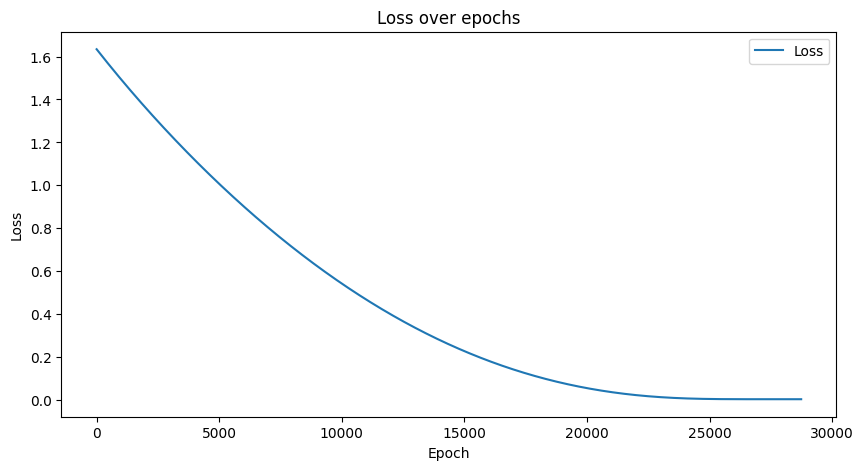

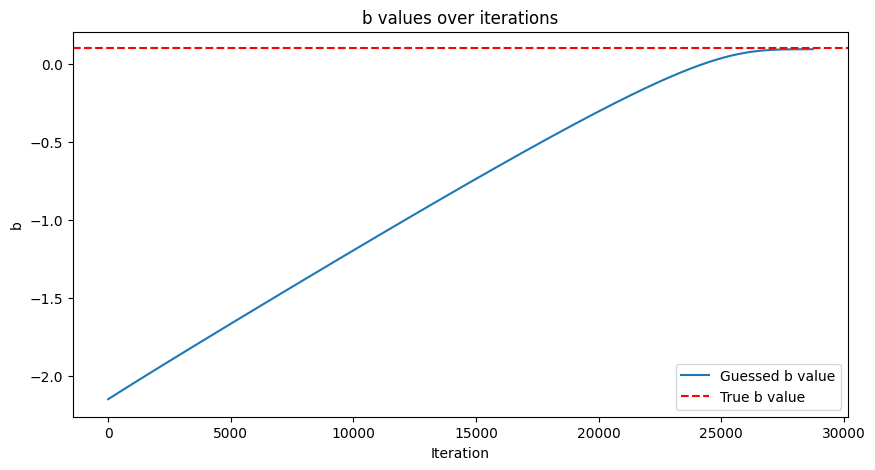

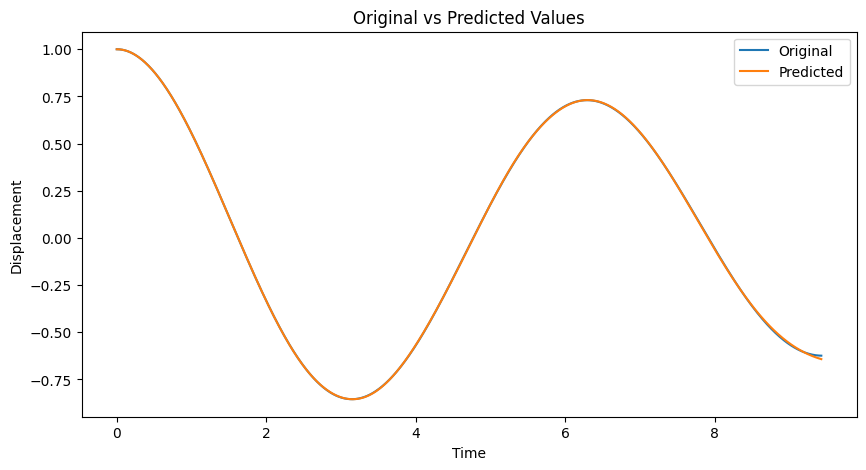

In [12]:
epochs = 100000
optimizer_b = torch.optim.Adam([model.b], lr=1e-4)
loss_values = []
#m_values = []
b_values = []
#k_values = []
t_grad = t.requires_grad_(True)

# Initialize variables for early stopping
min_loss = np.inf
epochs_no_improve = 0
wait_for = 100
least_loss = 0

epoch = 0
while(True):
    epoch += 1
    optimizer_b.zero_grad()
    x_pred = model(t)
    x_pred_eq = model(t_grad)
    loss = physics_loss_fn(x_pred, x ,x_pred_eq, t_grad, m, model.b, k, y0)
    epoch_loss = loss.item()
    loss_values.append(epoch_loss)
    #m_values.append(model.m.item())
    b_values.append(model.b.item())
    #k_values.append(model.k.item())
    loss.backward()
    optimizer_b.step()

    # Print the loss for every 100th epoch
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")
        
    if(loss<least_loss):
        break

    # Update early stopping variables
    if loss < min_loss:
        min_loss = loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check for early stopping
    if epochs_no_improve >= wait_for:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if epoch > epochs:
        break

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

"""
# Plot m values
plt.figure(figsize=(10, 5))
plt.plot(m_values, label='Guessed m value')
plt.axhline(y=m, color='r', linestyle='--', label='True m value')
plt.title('m values over iterations')
plt.xlabel('Iteration')
plt.ylabel('m')
plt.legend()
plt.show()
"""

# Plot b values
plt.figure(figsize=(10, 5))
plt.plot(b_values, label='Guessed b value')
plt.axhline(y=b, color='r', linestyle='--', label='True b value')
plt.title('b values over iterations')
plt.xlabel('Iteration')
plt.ylabel('b')
plt.legend()
plt.show()

"""
# Plot k values
plt.figure(figsize=(10, 5))
plt.plot(k_values, label='Guessed k value')
plt.axhline(y=k, color='r', linestyle='--', label='True k value')
plt.title('k values over iterations')
plt.xlabel('Iteration')
plt.ylabel('k')
plt.legend()
plt.show()
"""

# Generate predictions on the training data
x_real = x.detach().numpy()
x_pred = model(t).detach().numpy()
t_np = t.detach().numpy()

# Plot the original and predicted values
plt.figure(figsize=(10, 5))
plt.plot(t_np, x_real, label='Original')
plt.plot(t_np, x_pred, label='Predicted')
plt.title('Original vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend()
plt.show()


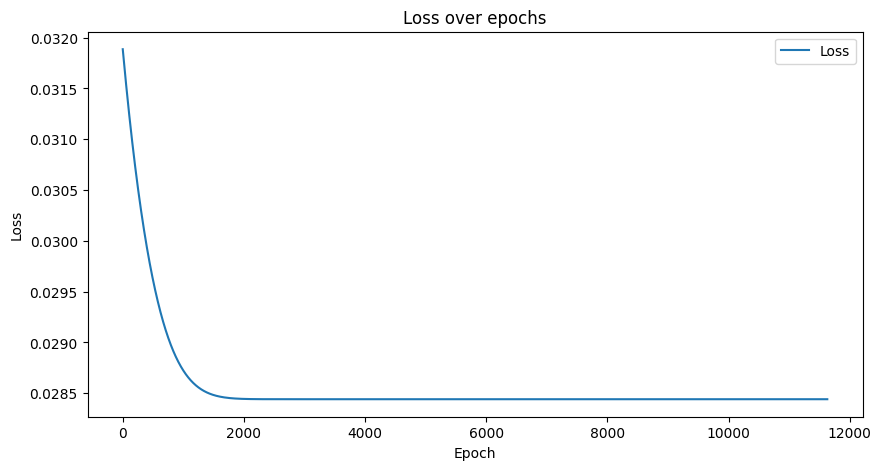

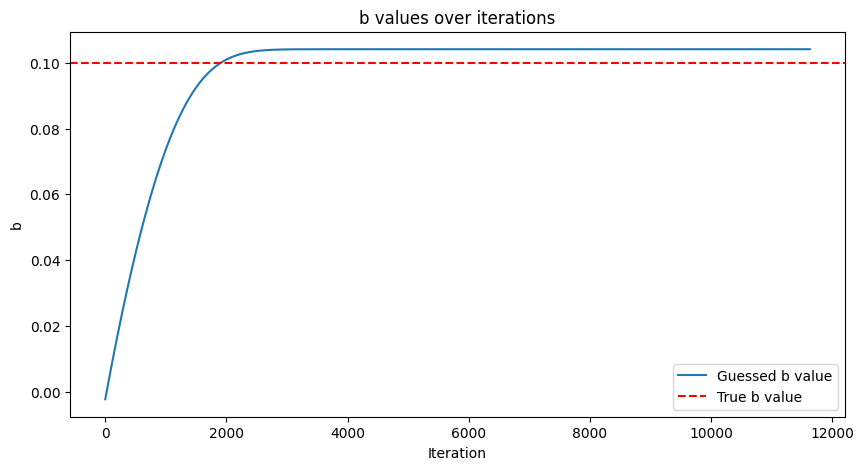

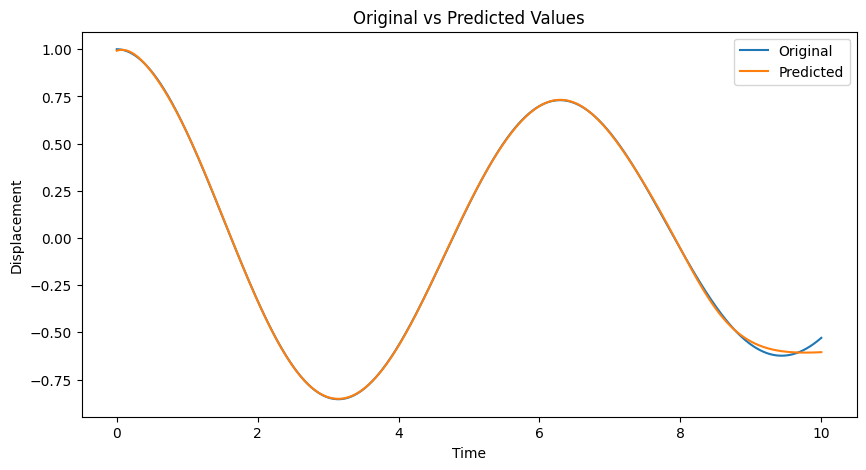

In [19]:

# Plot the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot b values
plt.figure(figsize=(10, 5))
plt.plot(b_values, label='Guessed b value')
plt.axhline(y=b, color='r', linestyle='--', label='True b value')
plt.title('b values over iterations')
plt.xlabel('Iteration')
plt.ylabel('b')
plt.legend()
plt.show()

# Generate predictions on the training data
x_real = x.detach().numpy()
x_pred = model(t).detach().numpy()
t_np = t.detach().numpy()

# Plot the original and predicted values
plt.figure(figsize=(10, 5))
plt.plot(t_np, x_real, label='Original')
plt.plot(t_np, x_pred, label='Predicted')
plt.title('Original vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend()
plt.show()


In [14]:
model.b

Parameter containing:
tensor([0.0938], requires_grad=True)